In [34]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import DaleTasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
help(write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [36]:
#define area of interest
query = {
    
        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
'y': (-35.636, -35.905),
'x': (144.102, 144.387),
    
# jerrabombera wetland
#'y': (-35.288, -35.346),
#'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

    #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-05-01', '2018-12-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [37]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 30, x: 1140, y: 1289)
Coordinates:
  * time             (time) datetime64[ns] 2018-05-08T00:08:19.500000 ... 2018-12-25T00:14:53
  * y                (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x                (x) float64 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 706 695 685 685 ... -999 -999 -999 -999
    blue             (time, y, x) int16 732 748 741 733 ... -999 -999 -999 -999
    green            (time, y, x) int16 1004 1036 1023 1008 ... -999 -999 -999
    red              (time, y, x) int16 1383 1394 1371 1361 ... -999 -999 -999
    nir              (time, y, x) int16 2290 2330 2291 2267 ... -999 -999 -999
    swir1            (time, y, x) int16 3355 3386 3344 3297 ... -999 -999 -999
    swir2            (time, y, x) int16 2252 2246 2215 2207 ... -999 -999 -999
Attributes:
    crs:      EPSG: 3577

In [38]:
#define number of total observations

total_obs = int(len(data_lst8.time))
total_obs

30

In [39]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 30, x: 1140, y: 1289)
Coordinates:
  * time          (time) datetime64[ns] 2018-05-08T00:08:19.500000 ... 2018-12-25T00:14:53
  * y             (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * x             (x) float64 1.091e+06 1.091e+06 ... 1.119e+06 1.119e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 16127 16127 16127
Attributes:
    crs:      EPSG: 3577

In [40]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 30, y: 1289, x: 1140)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-08T00:08:19.500000 ... 2018-12-25T00:14:53
  * y        (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06 -3.977e+06
  * 

In [41]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)


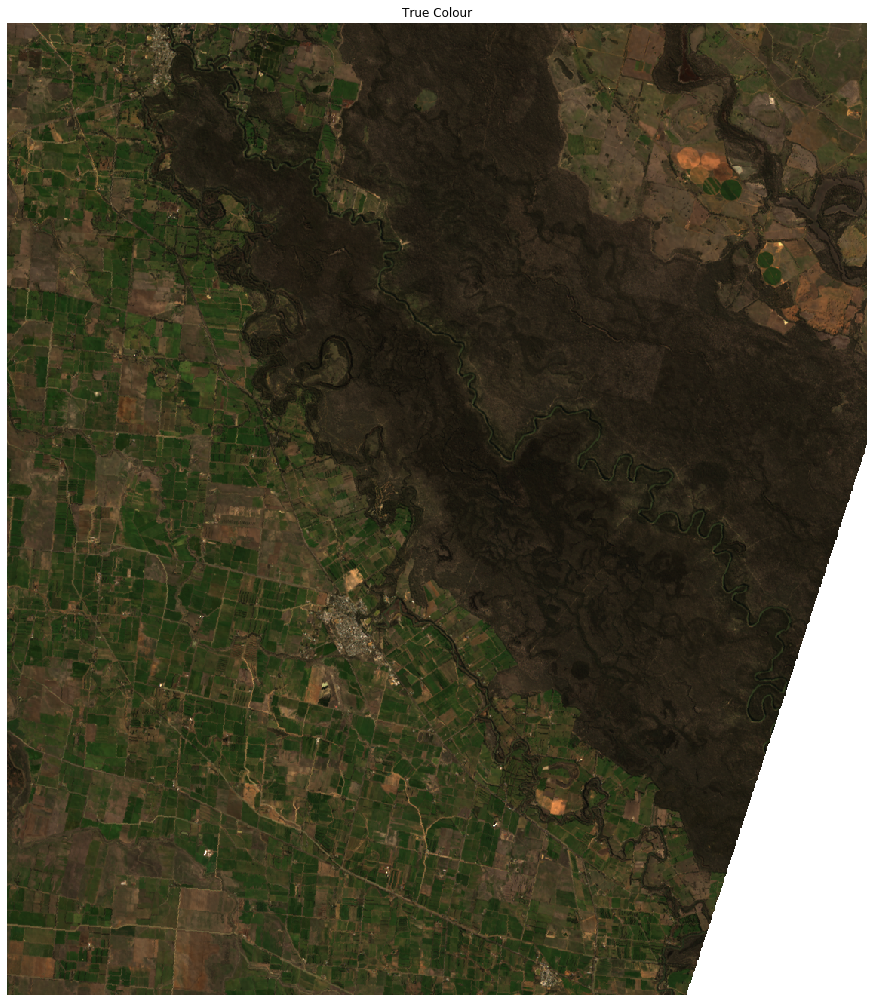

In [42]:
data_lst8_once = Masked_lst8_data.isel(time=9)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 3000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

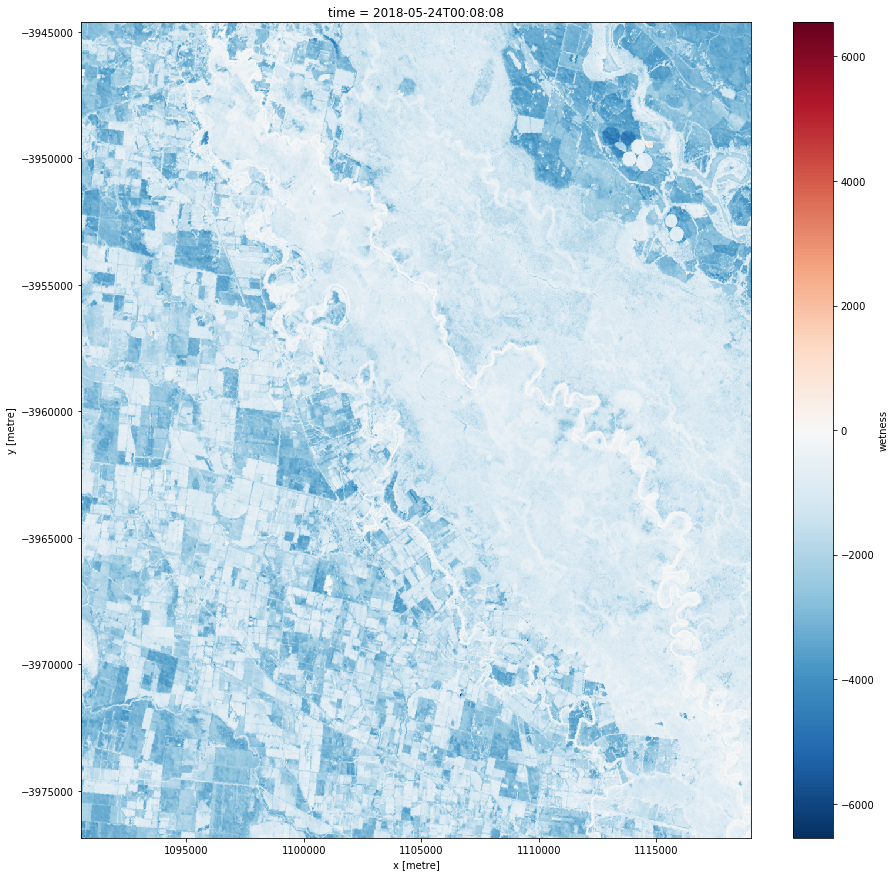

In [43]:
#Do tassled Cap transformation
TCI = DaleTasseledCapTools.thresholded_tasseled_cap(Masked_lst8_data,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)
tcw = TCI['wetness']
tcg = TCI['greenness']
tcb = TCI['brightness']

tcw.isel(time=2).plot(figsize =(15,15))

In [44]:
#Apply wet classification over Data

wet_values = tcw.where(tcw<-300, 1) #first turn everything wet to 1
wet_values = wet_values.where(tcw>=-300,0) #then turn everything dry to 0

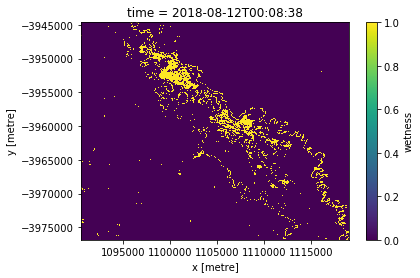

In [45]:
wet_values.isel(time=12).plot()

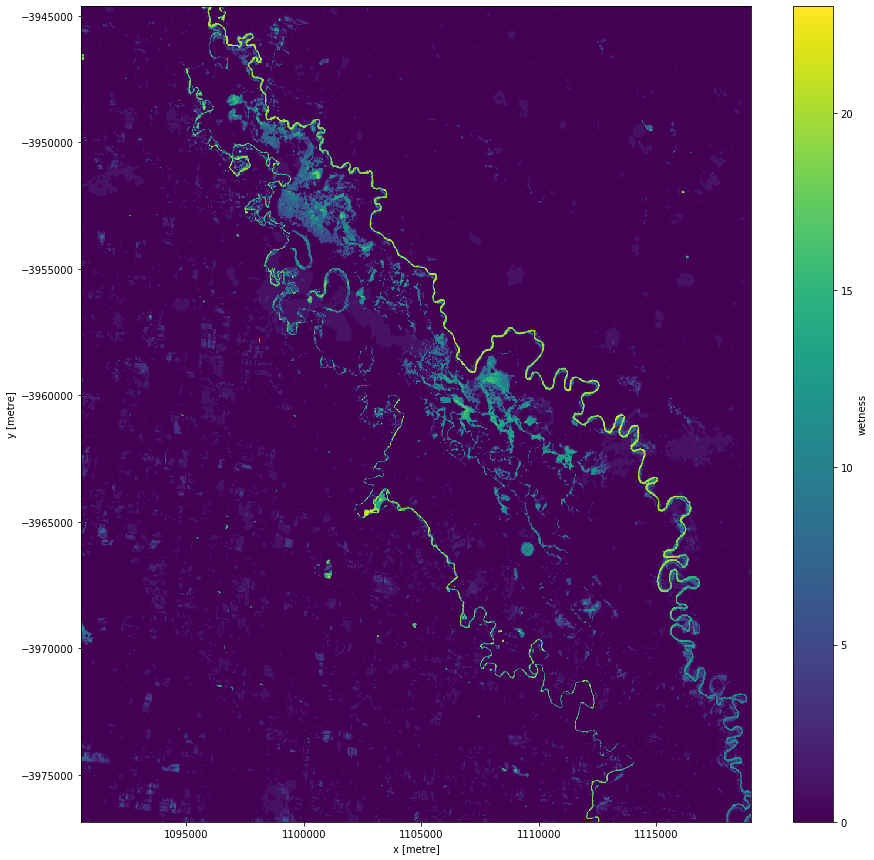

In [46]:
#Combine all date slices to gether to create a wetness frequency

wet_frequency = wet_values.sum(dim='time')
wet_frequency.plot(figsize =(15,15))

In [47]:
#Calulate what number of wetness observations is equal to X% of total observations

precent_threhold = total_obs*0.05
precent_threhold

1.5

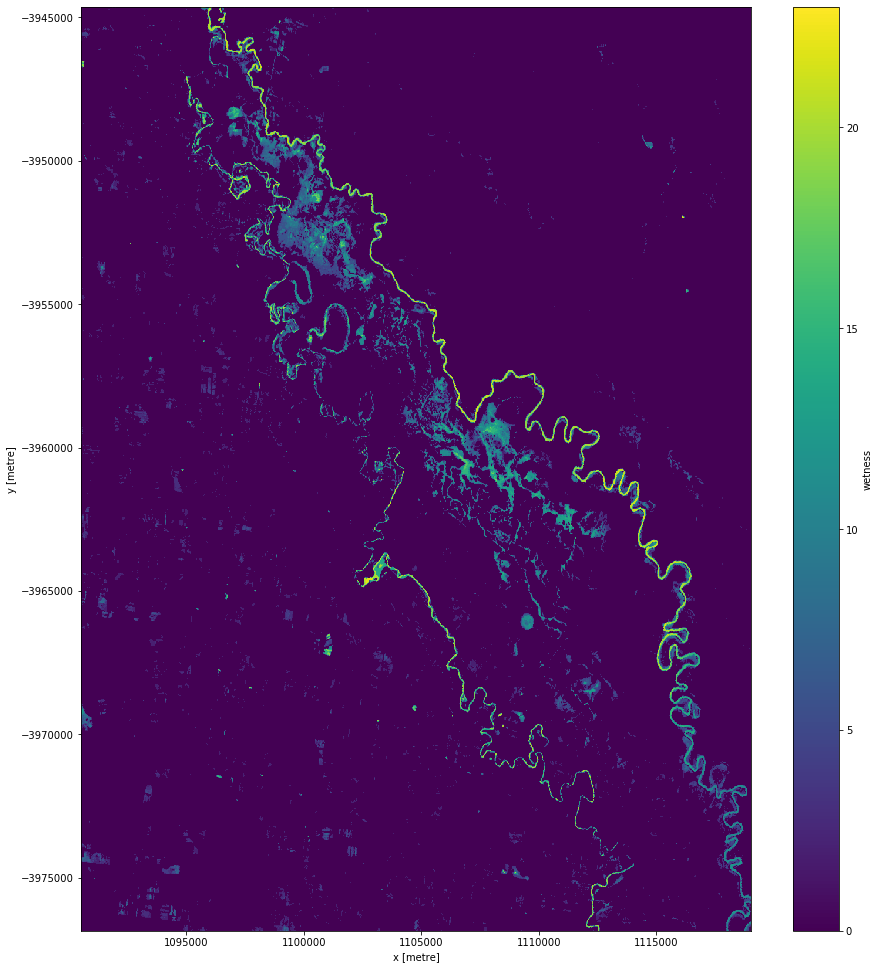

In [48]:
#apply X% threshold to find area inundated for X amount of time

persistant_wet = wet_frequency.where(wet_frequency>precent_threhold,0)

persistant_wet.plot(figsize =(15,17))

In [49]:

# #load wofs filtered summary
wofs_filtered_summary= dc.load(product = 'wofs_annual_summary', **query)
wofs_filtered_summary

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [50]:
wofs_water = wofs_filtered_summary['count_wet']
wofs_water

KeyError: 'count_wet'

In [ ]:
wofs_water.plot(figsize =(15,15))

In [ ]:
Inundated_veg = persistant_wet.where(wofs_water<1,0)
Inundated_veg.plot(figsize =(15,15))

In [ ]:
# persistant_wet = persistant_wet.where(persistant_wet<=0,1)

In [ ]:
# persistant_wet.plot(figsize =(15,15))

In [ ]:
persistant_wet

In [ ]:
once_TCI = TCI.isel(time=0)

In [ ]:
once_TCI['persist_wet']=persistant_wet
once_TCI

In [ ]:

wet_TCI = once_TCI.drop(['greenness','greenness_thresholded','brightness_thresholded','brightness','wetness','wetness_thresholded'])
#wet_TCI = wet_TCI.isel(time=0)
wet_TCI

In [ ]:
wet_TCI.persist_wet.plot()

In [ ]:
#wofs_water

In [ ]:
# wet_TCI

In [51]:
#save some tassled cap to file
TCT_once = TCI.isel(time=12)
TCT_once

<xarray.Dataset>
Dimensions:                 (x: 1140, y: 1289)
Coordinates:
    time                    datetime64[ns] 2018-08-12T00:08:38
  * y                       (y) float64 -3.945e+06 -3.945e+06 ... -3.977e+06
  * x                       (x) float64 1.091e+06 1.091e+06 ... 1.119e+06
Data variables:
    greenness               (y, x) float64 390.4 428.1 ... 1.207e+03 1.288e+03
    greenness_thresholded   (y, x) float64 nan nan nan ... 1.207e+03 1.288e+03
    brightness              (y, x) float64 3.267e+03 3.309e+03 ... 1.915e+03
    brightness_thresholded  (y, x) float64 nan nan nan nan ... nan nan nan nan
    wetness                 (y, x) float64 -2.385e+03 -2.372e+03 ... -475.5
    wetness_thresholded     (y, x) float64 nan nan nan ... -370.0 -464.0 -475.5
Attributes:
    crs:      EPSG: 3577

In [52]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
write_geotiff('/g/data/u46/users/ck9738/Datasets/Tasselled_cap_tifs/Gunbower_daleCoeff_20180812.tif',TCT_once)